<span style="color:yellow">two kernel based extract random tile from wsi</span>

In [1]:
# run based "cellprofiler" kernel
import os
from histolab.slide import Slide
from histolab.tiler import RandomTiler

ModuleNotFoundError: No module named 'histolab'

In [ ]:
os.chdir('/data/dk/endometrium/raw')
path = '/data/dk/endometrium/raw'
processed_path = '/home/ma/dk/endometrium/randomtile/'
file_list = os.listdir(path)
for file_name in file_list:
    print(file_name)
    file_path = os.path.join(path, file_name)
    sample  = Slide(file_path, processed_path)
    print(f"Slide name: {sample.name}")
    print(f"Levels: {sample.levels}")
    print(f"Dimensions at level 0: {sample.dimensions}")
    print(f"Dimensions at level 1: {sample.level_dimensions(level=1)}")
    print(f"Dimensions at level 2: {sample.level_dimensions(level=2)}")
    random_tiles_extractor = RandomTiler(
    tile_size=(512, 512),
    n_tiles=20,
    level=1,
    seed=42,
    check_tissue=True, # default
    tissue_percent=40.0, # default
    prefix=os.path.splitext(file_name)[0]+'_', # save tiles in the "random" subdirectory of slide's processed_path
    suffix=".png")# default
    random_tiles_extractor.extract(sample)
    random_tiles_extractor.locate_tiles(
    slide=sample,
    linewidth=2,
    scale_factor=24,  # default
    alpha=128,  # default
    outline="#40E0D0" # default
    )


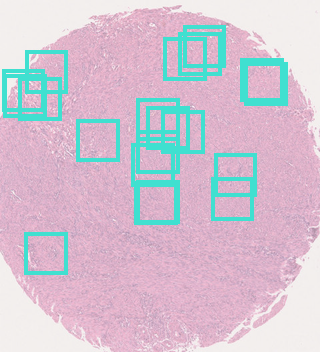

In [5]:
random_tiles_extractor.locate_tiles(
slide=sample,
linewidth=4,
scale_factor=24,  # default
alpha=128,  # default
outline="#40E0D0" # default
)

<span style="color:yellow">'vahadane' kernel based normalize tiles</span>

In [1]:
import cv2
import matplotlib.pyplot as plt
import torchstain
import torch
from torchvision import transforms
import time
from PIL import Image
import numpy as np



In [2]:
import os 
os.chdir("/home/ma/torchstain/")
root_dir = '/data/dk/endometrium/'

In [ ]:
size = 1024
# target = cv2.resize(cv2.cvtColor(cv2.imread("/data/dk/ucec/randomtile/TCGA-A5-A0GA-01Z-00-DX1.D691BFC9-05DF-4815-9DCE-84B343C7015A_tile_8_level1_29636-35340-31684-37388.png"), cv2.COLOR_BGR2RGB), (size, size))
target = cv2.resize(cv2.cvtColor(cv2.imread("./data/target.png"), cv2.COLOR_BGR2RGB), (size, size))
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
normalizer.fit(target)
for file in os.listdir('/data/dk/endometrium/randomtile/'):
    to_transform = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(root_dir,'randomtile/',file)), cv2.COLOR_BGR2RGB), (size, size))
    T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
    ])
    torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
    torch_normalizer.fit(T(target))
    norm, H, E = normalizer.normalize(I=to_transform, stains=True)
    print(file)
    filename = os.path.join('/data/dk/endometrium/normalizedtile/',file)
    norm2  = cv2.cvtColor(norm, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, norm2)


In [ ]:
img = Image.open('/home/ma/dk/endometrium/CLAM/output_image.png').convert('RGB')
target = cv2.resize(cv2.cvtColor(cv2.imread("/home/ma/torchstain/data/target.png"), cv2.COLOR_BGR2RGB), (1024, 1024))
to_transform = cv2.resize(np.array(img), (1024, 1024))
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
normalizer.fit(target)

T = transforms.Compose([
transforms.ToTensor(),
transforms.Lambda(lambda x: x*255)
])
torch_normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
torch_normalizer.fit(T(target))
norm, H, E = normalizer.normalize(I=to_transform, stains=True)
plt.imshow(norm)
plt.savefig('/data/dk/endometrium/test/target.png')

In [ ]:
img = "/home/ma/torchstain/data/target.png"
def is_empty(img):
   # Reading Image
   image = cv2.imread(img, 0)
   np.reshape(image, (-1,1))
   u, count_unique = np.unique(image, return_counts =True)
   
   if count_unique.size< 10:
      return "Image is empty"
   else:
      return "Image is not empty"

print(is_empty('whh.jpg'))

Image is empty


[ WARN:0@5849.948] global loadsave.cpp:248 findDecoder imread_('whh.jpg'): can't open/read file: check file path/integrity


In [ ]:
image = cv2.imread('/home/ma/dk/endometrium/CLAM/output_image.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
threshold = 200 
white_pixel_count = np.sum(gray_image > threshold)
total_pixels = gray_image.size
white_percentage = (white_pixel_count / total_pixels) * 100

white_threshold_percentage = 90  # Adjust this value as needed
if white_percentage >= white_threshold_percentage:
    print("The image is mostly white.")
else:
    print("The image is not mostly white.")

The image is mostly white.


<span style="font-size: 26px;color:red">Tile Feature Extract</span><br>
<span style="color:yellow">after extract the random tile and normalize the image , run cellprofiler as a python package to extract morphology of wsi</span><br>
kernel : 'cf'

In [2]:
import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.utilities.java
import pathlib
import os
cellprofiler_core.preferences.set_headless()
cellprofiler_core.utilities.java.start_java()

In [3]:
os.chdir('/data/dk/endometrium/')

PosixPath('/data/dk/endometrium')

In [6]:

pipeline = cellprofiler_core.pipeline.Pipeline()
pipeline.load("/data/dk/cf/pathomic.cppipe")
current_dir = pathlib.Path().absolute()
cellprofiler_core.preferences.set_default_output_directory(f"{current_dir}/cf_out")
file_list = list(pathlib.Path('.').absolute().glob('normalizedtile/*.png'))
files = [file.as_uri() for file in file_list]
pipeline.read_file_list(files)

In [8]:
output_measurements = pipeline.run()


/data/dk/micromamba/envs/cf/lib/python3.8/site-packages/scipy/ndimage/_measurements.py:1407: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
/data/dk/micromamba/envs/cf/lib/python3.8/site-packages/cellprofiler/modules/measureobjectneighbors.py:611: RuntimeWarning: invalid value encountered in divide
  percent_touching = pixel_count * 100 / perimeters
/data/dk/micromamba/envs/cf/lib/python3.8/site-packages/skimage/filters/thresholding.py:701: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/ma/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ma/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ma/.local/lib/python3.8/site-packages/n

In [5]:
cellprofiler_core.utilities.java.stop_java()